# Package the stock and weather together and build features

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
basedir = '/Users/bono/demo_projects/weather_stocks/'
s_file = basedir+'data/df_stocks.pkl'
w_file = basedir+'data/df_weather_alt.pkl'
s = open(s_file,'rb')
w = open(w_file,'rb')
df_stocks = pickle.load(s)
df_weather = pickle.load(w)
s.close()
w.close()


In [3]:
df_stocks.head()

,Open,High,Low,Close,Adj Close,Volume
DATE,,,,,,
1950-01-03,200.130005,200.199997,197.729996,198.889999,198.889999,1260000
1950-01-04,198.889999,200.550003,198.259995,200.199997,200.199997,1890000
1950-01-05,200.199997,201.759995,199.690002,200.570007,200.570007,2550000
1950-01-06,200.570007,201.619995,199.839996,200.960007,200.960007,2010000
1950-01-09,201.940002,202.919998,200.860001,201.979996,201.979996,2520000


In [4]:
df_weather.head()

,STATION,NAME,ACMH,ACMH_ATTRIBUTES,ACSH,ACSH_ATTRIBUTES,AWND,AWND_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,...,WT17,WT17_ATTRIBUTES,WT18,WT18_ATTRIBUTES,WT19,WT19_ATTRIBUTES,WT21,WT21_ATTRIBUTES,WT22,WT22_ATTRIBUTES
DATE,,,,,,,,,,,,,,,,,,,,,
1940-01-01,USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,NaN,NaN,0.00,",,0",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1940-01-02,USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,NaN,NaN,0.00,",,0",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1940-01-03,USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,NaN,NaN,0.00,",,0",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1940-01-04,USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,NaN,NaN,0.00,",,0",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1940-01-05,USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,NaN,NaN,0.03,",,0",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print(df_weather.shape)
print(df_stocks.shape)


(29261, 66)
(17613, 6)


# Add features to the weather data

We want to add cumulative features such as the number of consecutive rainy days.

The key for the weather feaures formated as WTXX is below
![weatherkey](/Users/bono/demo_projects/weather_stocks/data/weathercodes.png)

### add a booliean "bad weather" index + the number of consecutive days of bad weather

In [6]:
#First call any precipitation bad weather
rain = df_weather['PRCP'] > 0
rain = rain.astype(int)
#and snow
snow = df_weather['SNOW'] > 0
snow = snow.astype(int)

bad = snow + rain

In [7]:
#also count rain and freezing rain flags as bad weather
bad = bad + df_weather['WT16'].fillna(0) + df_weather['WT17'].fillna(0)
# include drizzle, hail, ice pellets, etc
bad = bad + df_weather['WT14'].fillna(0) + df_weather['WT04'].fillna(0) + df_weather['WT05'].fillna(0)
# include high or damaging winds
bad = bad + df_weather['WT11'].fillna(0)
#include heavy fog
bad = bad + df_weather['WT02'].fillna(0)
bad[0:8]

DATE
1940-01-01    0.0
1940-01-02    0.0
1940-01-03    0.0
1940-01-04    0.0
1940-01-05    2.0
1940-01-06    0.0
1940-01-07    0.0
1940-01-08    2.0
dtype: float64

In [8]:
#reduce all non zero values to 1
bad[bad != 0] = 1
bad[0:8]

DATE
1940-01-01    0.0
1940-01-02    0.0
1940-01-03    0.0
1940-01-04    0.0
1940-01-05    1.0
1940-01-06    0.0
1940-01-07    0.0
1940-01-08    1.0
dtype: float64

In [9]:
#count the number of consectutive days of bad weather
n_bad = (bad * (bad.groupby((bad != bad.shift()).cumsum()).cumcount() + 1))
n_bad[0:8]

DATE
1940-01-01    0.0
1940-01-02    0.0
1940-01-03    0.0
1940-01-04    0.0
1940-01-05    1.0
1940-01-06    0.0
1940-01-07    0.0
1940-01-08    1.0
dtype: float64

In [10]:
#add the consecutive days of bad weather to the df 
df_weather['n_bad'] = n_bad

### now count the consecutive days of good weather

In [11]:
#copy the bad index and reverse it
good = bad
good.replace({0:1, 1:0}, inplace=True)
#count the number of consectutive days of bad weather
n_good = (good * (good.groupby((good != good.shift()).cumsum()).cumcount() + 1))
n_good[0:8]

DATE
1940-01-01    1.0
1940-01-02    2.0
1940-01-03    3.0
1940-01-04    4.0
1940-01-05    0.0
1940-01-06    1.0
1940-01-07    2.0
1940-01-08    0.0
dtype: float64

In [12]:
#add the consecutive days of good weather to the df 
df_weather['n_good'] = n_good

In [13]:
df_weather.head()

,STATION,NAME,ACMH,ACMH_ATTRIBUTES,ACSH,ACSH_ATTRIBUTES,AWND,AWND_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,...,WT18,WT18_ATTRIBUTES,WT19,WT19_ATTRIBUTES,WT21,WT21_ATTRIBUTES,WT22,WT22_ATTRIBUTES,n_bad,n_good
DATE,,,,,,,,,,,,,,,,,,,,,
1940-01-01,USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,NaN,NaN,0.00,",,0",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
1940-01-02,USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,NaN,NaN,0.00,",,0",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0
1940-01-03,USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,NaN,NaN,0.00,",,0",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0
1940-01-04,USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,NaN,NaN,0.00,",,0",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,4.0
1940-01-05,USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,NaN,NaN,0.03,",,0",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0


# Add features to the stock data

In [14]:
start = df_stocks['Open']
end = df_stocks['Close']
df_stocks['PercentChange'] = 100.0*(end - start)/start
df_stocks.head()

,Open,High,Low,Close,Adj Close,Volume,PercentChange
DATE,,,,,,,
1950-01-03,200.130005,200.199997,197.729996,198.889999,198.889999,1260000,-0.619600
1950-01-04,198.889999,200.550003,198.259995,200.199997,200.199997,1890000,0.658654
1950-01-05,200.199997,201.759995,199.690002,200.570007,200.570007,2550000,0.184820
1950-01-06,200.570007,201.619995,199.839996,200.960007,200.960007,2010000,0.194446
1950-01-09,201.940002,202.919998,200.860001,201.979996,201.979996,2520000,0.019805


In [15]:
print(df_weather.shape)
print(df_stocks.shape)

(29261, 68)
(17613, 7)


## join the weather data with the stocks data
taking an inner join because we only want stock data when we have weather data, and vice versa.
all cumulative weather features should be calculated before this step

In [16]:
df_all = df_weather.merge(df_stocks,left_index=True,right_index=True, how='inner')

In [17]:
print(df_all.shape)

(17613, 75)


## Make some basic plots

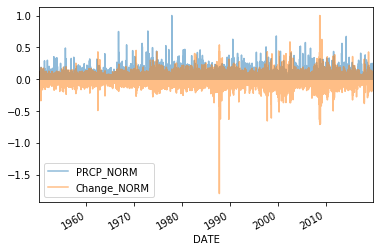

In [18]:
#normalize some vars just for visualzation
df_all['Change_NORM'] = df_all['PercentChange']/df_all['PercentChange'].max()
df_all['PRCP_NORM'] = df_all['PRCP']/df_all['PRCP'].max()
df_all.plot(y=['PRCP_NORM','Change_NORM'],alpha=0.5)

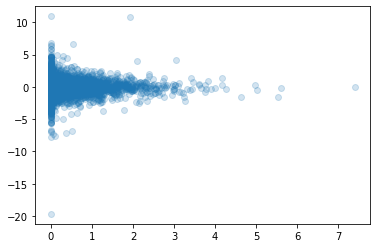

In [19]:
plt.scatter(df_all['PRCP'], df_all['PercentChange'],alpha=0.2)

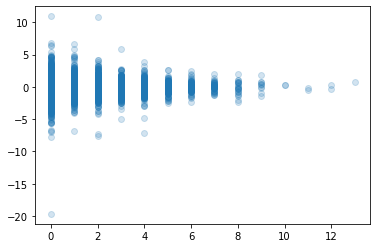

In [20]:
plt.scatter(df_all['n_bad'], df_all['PercentChange'],alpha=0.2)

# Store the final df as a pkl file

In [21]:
file = basedir+'data/df_all.pkl'
df_all.to_pickle(file)
df_all.shape

(17613, 77)

0.04343220153745297 +/- 0.09369244413399458
0.001001385656112771 +/- 0.12091280933026013
0.0205004382508874 +/- 0.1473606783124773
0.020680713332076422 +/- 0.17328251854098878
0.004011009187878839 +/- 0.22377290243104347
0.016080583278045887 +/- 0.256373020691985


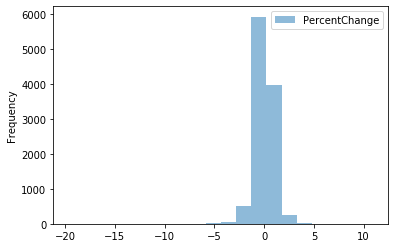

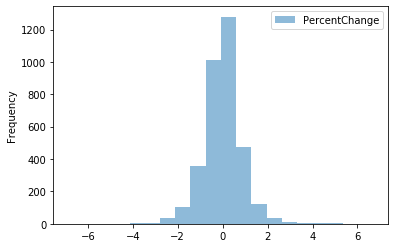

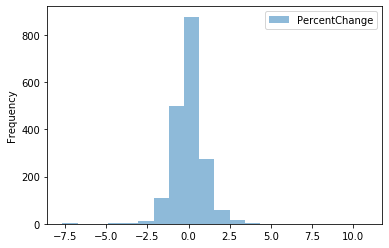

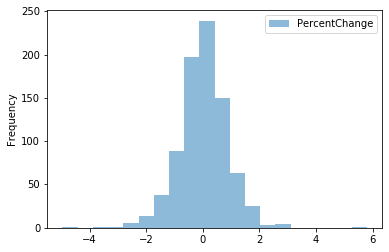

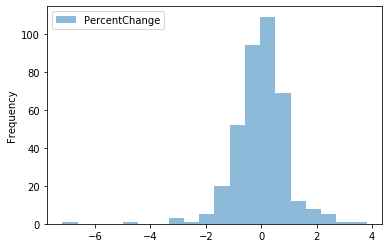

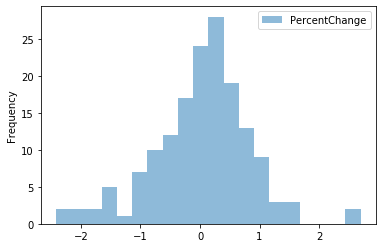

In [22]:
y='PercentChange'
#look at trends for bad weather
df = df_all[df_all['n_bad'] == 0]
df.plot(y=y,kind='hist', density=0, bins=20, stacked=True, alpha=.5)
print(df[y].mean(), "+/-",  np.sqrt(df[y].sem()))
df = df_all[df_all['n_bad'] == 1]
df.plot(y=y,kind='hist', density=0, bins=20, stacked=True, alpha=.5)
print(df[y].mean(), "+/-",  np.sqrt(df[y].sem()))
df = df_all[df_all['n_bad'] == 2]
df.plot(y=y,kind='hist', density=0, bins=20, stacked=False, alpha=.5)
print(df[y].mean(), "+/-",  np.sqrt(df[y].sem()))
df = df_all[df_all['n_bad'] == 3]
df.plot(y=y,kind='hist', density=0, bins=20, stacked=False, alpha=.5)
print(df[y].mean(), "+/-",  np.sqrt(df[y].sem()))
df = df_all[df_all['n_bad'] == 4]
df.plot(y=y,kind='hist', density=0, bins=20, stacked=False, alpha=.5)
print(df[y].mean(), "+/-",  np.sqrt(df[y].sem()))
df = df_all[df_all['n_bad'] == 5]
df.plot(y=y,kind='hist', density=0, bins=20, stacked=False, alpha=.5)
print(df[y].mean(), "+/-",  np.sqrt(df[y].sem()))


In [23]:
df_all.shape

(17613, 77)

In [24]:
df_all

,STATION,NAME,ACMH,ACMH_ATTRIBUTES,ACSH,ACSH_ATTRIBUTES,AWND,AWND_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,...,n_good,Open,High,Low,Close,Adj Close,Volume,PercentChange,Change_NORM,PRCP_NORM
DATE,,,,,,,,,,,,,,,,,,,,,
1950-01-03,USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,NaN,NaN,0.05,",,Z",...,0.0,200.130005,200.199997,197.729996,198.889999,198.889999,1260000,-0.619600,-0.056673,0.006757
1950-01-04,USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,NaN,NaN,0.00,",,Z",...,1.0,198.889999,200.550003,198.259995,200.199997,200.199997,1890000,0.658654,0.060245,0.000000
1950-01-05,USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,NaN,NaN,0.00,"T,,Z",...,2.0,200.199997,201.759995,199.690002,200.570007,200.570007,2550000,0.184820,0.016905,0.000000
1950-01-06,USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,NaN,NaN,0.02,",,0",...,0.0,200.570007,201.619995,199.839996,200.960007,200.960007,2010000,0.194446,0.017785,0.002703
1950-01-09,USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,NaN,NaN,0.00,",,0",...,2.0,201.940002,202.919998,200.860001,201.979996,201.979996,2520000,0.019805,0.001811,0.000000
1950-01-10,USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,NaN,NaN,0.46,",,Z",...,0.0,201.979996,202.039993,200.130005,201.169998,201.169998,2160000,-0.401029,-0.036681,0.062162
1950-01-11,USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,NaN,NaN,0.00,",,Z",...,1.0,201.169998,202.419998,200.520004,201.610001,201.610001,2630000,0.218722,0.020006,0.000000
1950-01-12,USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,NaN,NaN,0.00,"T,,Z",...,2.0,201.610001,202.080002,197.529999,197.929993,197.929993,2970000,-1.825310,-0.166955,0.000000
1950-01-13,USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,NaN,NaN,0.18,",,Z",...,0.0,197.929993,197.929993,193.940002,196.809998,196.809998,3330000,-0.565854,-0.051757,0.024324
